------------------------------
#### Embedding Adapters 
-------------------------------------

- in the context of Retrieval-Augmented Generation (RAG) models refer to a specific mechanism that enhances the `query formulation process` for improved retrieval performance in a natural language processing (NLP) pipeline.
- RAG combines `retrieval` and `generative capabilities`, allowing models to retrieve relevant documents from a knowledge base or database and then use this information to generate responses.

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
import umap
from tqdm import tqdm

import torch

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename          = r'./data/microsoft_annual_report_2022.pdf', 
                                collection_name   = 'microsoft_annual_report_2022', 
                                embedding_function= embedding_function)
chroma_collection.count()

D:\ANACONDA\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


349

In [3]:
embeddings     = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

D:\ANACONDA\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [4]:
import pickle

In [5]:
# Save the UMAP model to a file
with open('umap_model.pkl', 'wb') as f:
    pickle.dump(umap_transform, f)

In [6]:
# Load the UMAP model from the file
with open('umap_model.pkl', 'rb') as f:
    umap_transform = pickle.load(f)

In [7]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|███████████████████████████████████████████████████████████████████████| 349/349 [05:26<00:00,  1.07it/s]


In [8]:
# Assuming 'projected_dataset_embeddings' is the transformed dataset
with open('projected_embeddings.pkl', 'wb') as f:
    pickle.dump(projected_dataset_embeddings, f)

In [9]:
with open('projected_embeddings.pkl', 'rb') as f:
    projected_dataset_embeddings = pickle.load(f)

In [10]:
import os
import openai
from openai import OpenAI

openai.api_key = os.environ['OPENAI_API_KEY']

In [11]:
openai_client = OpenAI()

#### Creating a dataset

In [12]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [14]:
generated_queries = generate_queries()

for query in generated_queries:
    print(query)

1. What are the company's total revenues for the year?
2. What is the company's net income for the year?
3. How much cash does the company have on hand?
4. What is the company's debt-to-equity ratio?
5. What were the company's operating expenses for the year?
6. How much did the company spend on research and development?
7. What is the company's earnings per share?
8. How much inventory does the company currently hold?
9. What is the company's current ratio?
10. How much did the company pay in dividends?
11. What is the company's return on investment?
12. How much did the company spend on capital expenditures?
13. What are the company's current liabilities?
14. How much cash flow did the company generate from operating activities?
15. What is the company's market capitalization?


In [15]:
results = chroma_collection.query(query_texts= generated_queries, 
                                  n_results  = 10, 
                                  include=['documents', 'embeddings'])

retrieved_documents = results['documents']

In [16]:
len(retrieved_documents)

15

In [17]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [18]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [19]:
adapter_query_embeddings = []
adapter_doc_embeddings   = []
adapter_labels           = []

In [20]:
# time = 10 mins
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|█████████████████████████████████████████████████████████████████████████| 15/15 [01:27<00:00,  5.87s/it]


In [22]:
len(adapter_labels)           # 15 queries , 10 results each

150

In [23]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings   = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels           = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

- adapter_query_embeddings: Embeddings for the queries (e.g., query representations).
- adapter_doc_embeddings: Embeddings for the documents (e.g., document representations).
- adapter_labels: Labels or target values for each query-document pair, which could represent relevance scores or other training signals.

Each entry in the dataset will be a tuple (query_embedding, doc_embedding, label)

In [24]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

#### Setting up the model

- The function first transforms the `query_embedding` using matrix multiplication with the `adaptor_matrix`.
- This step applies a linear transformation, potentially to `align` the query embedding with the document embedding space or adjust it to capture certain task-specific information.

In [25]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

- After transforming the query embedding, the function computes the cosine similarity between the updated_query_embedding and the document_embedding.
- Cosine similarity is commonly used to measure the similarity between two vectors, with values ranging from -1 (opposite) to 1 (identical in direction).

`Usage and Purpose`

- **Purpose**: This function is designed to assess the **relevance or similarity** between a query and a document by first transforming the query into a potentially more compatible space using the adapter matrix. The transformation aligns the query embedding to a new space or adjusts it to better match the document embedding, enhancing similarity calculation.

- **Applications**: Such a function is especially useful in tasks like **information retrieval** and **document matching**, where optimizing query-document similarity is essential. It finds applications in dual encoder models (where separate encoders process queries and documents) and retrieval-augmented generation (RAG) frameworks, commonly used in search engines, recommendation systems, and question-answering applications. The transformation improves retrieval effectiveness by enhancing compatibility between the query and document representations.


In [28]:
def mse_loss(query_embedding, 
             document_embedding, 
             adaptor_matrix, 
             label):
    
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

- This function, `mse_loss`, computes the Mean Squared Error (MSE) loss between the predicted similarity score (from the model function) and the actual label. 

- calls the model function to get the `predicted similarity score` after transforming the `query_embedding` with the adaptor_matrix.

- Then, torch.nn.MSELoss() calculates the mean squared error between the predicted similarity score and the label.

In [29]:
# Example of computing MSE loss
query_embedding    = torch.randn(128)       # Example query embedding
document_embedding = torch.randn(128)       # Example document embedding
adaptor_matrix     = torch.randn(128, 128)  # Example adaptor matrix
label              = torch.tensor(0.8)      # Target similarity score

loss = mse_loss(query_embedding, document_embedding, adaptor_matrix, label)
print(f"MSE Loss: {loss.item()}")

MSE Loss: 0.5465078353881836


... back to the main code

#### Initialize the adaptor matrix

In [33]:
adapter_query_embeddings.shape

torch.Size([150, 384])

In [34]:
mat_size       = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [35]:
adapter_matrix.shape

torch.Size([384, 384])

In [36]:
min_loss    = float('inf')   # Keeps track of the lowest loss encountered during training.
best_matrix = None           # Stores the adapter matrix that resulted in the minimum loss.

for epoch in tqdm(range(100)):            # updating adapter_matrix each time.
    
    for query_embedding, document_embedding, label in dataset:
        
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()                     # computes the gradients with respect to adapter_matrix.
        with torch.no_grad():
            # is updated by moving in the direction of the negative gradient
            adapter_matrix -= 0.01 * adapter_matrix.grad

            # clears the gradients to prevent accumulation from previous iterations
            adapter_matrix.grad.zero_()
        

  0%|                                                                                 | 0/100 [00:00<?, ?it/s]D:\ANACONDA\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.34it/s]


In [37]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.5346463322639465


#### Understanding MSE with Binary Labels

1. **Labeling Context**:
   - **+1**: Indicates that the query and document are similar or relevant.
   - **-1**: Indicates that the query and document are dissimilar or not relevant.

2. **Mean Squared Error Calculation**:
   The Mean Squared Error (MSE) is calculated as:
  $$
   \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{\text{pred}, i} - y_{\text{true}, i})^2
$$
   where $( y_{\text{pred}, i} )$ is the predicted similarity score and $( y_{\text{true}, i} ) $is the actual label (+1 or -1).

3. **Possible Predictions**:
   In a binary classification scenario with labels of **+1** and **-1**, the predicted similarity scores can range between these two values (or even outside this range if not constrained):
   - A perfect prediction for **+1** would yield a score close to **+1**.
   - A perfect prediction for **-1** would yield a score close to **-1**.

##### Interpreting an MSE of 0.53

1. **Range of Predictions**:
   - If you have predictions that are consistently off by a small margin from the actual labels (+1 or -1), this can lead to an MSE of **0.53**. For instance:
     - For a label of **+1**, if the predicted score is **0.7**, the squared error is:
       \[
       (0.7 - 1)^2 = 0.09
       \]
     - For a label of **-1**, if the predicted score is **-0.5**, the squared error is:
       \[
       (-0.5 + 1)^2 = 0.25
       \]

2. **Comparative Goodness**:
   - In the context of MSE, a lower value indicates better performance. The maximum error for predictions close to the labels of **+1** and **-1** is **4** (for example, if predictions are **-1** for a true **+1** and vice versa).
   - An MSE of **0.53** suggests that the average squared difference between predictions and true labels is relatively small, indicating that the model is performing reasonably well.

##### Context Matters

1. **Task Sensitivity**: Whether **0.53** is a good MSE depends on the application:
   - In some applications (like fine-grained sentiment analysis), you might need a very low MSE (close to **0**).
   - In other scenarios, an MSE of **0.53** might be acceptable if it yields good classification accuracy or aligns well with business goals.

2. **Distribution of Errors**: Analyzing how predictions are distributed (i.e., how many fall into ranges near **+1** and **-1**) will also help assess whether **0.53** is acceptable or needs improvement.

##### Conclusion

In summary, an MSE of **0.53** in a binary similarity task with labels of **+1** and **-1** indicates that the model is producing predictions that are not too far from the true labels. While it may suggest reasonable performance, the evaluation should also consider the specific task requirements, the distribution of predictions, and other metrics to determine whether further optimization is necessary.


#### How the Adapter Matrix Influences Embeddings

The adapter matrix plays a crucial role in transforming and aligning embeddings in various machine learning models, particularly in scenarios involving dual encoders, retrieval-augmented generation (RAG), and other similar architectures. 

##### 1. Transformation of Query Embeddings
- **Purpose**: The primary function of the adapter matrix is to transform the `query embeddings` into a space that is more compatible with the `document embeddings`.
- **Mathematical Representation**:
  $$
  \text{Updated Query Embedding} = \text{Adapter Matrix} \times \text{Query Embedding}
  $$
- **Impact**: This transformation allows the model to better capture the relationship between the `queries` and `documents`, improving the relevance of the matching process.

##### 2. Alignment of Representations
- **Goal**: The adapter matrix helps in aligning the embeddings of different modalities (e.g., text and images) or different aspects of the same modality (e.g., different query types).
- **Outcome**: By adjusting the embeddings to be more similar to each other, the model can more effectively compare and retrieve relevant documents based on the input query.


In [38]:
test_vector = torch.ones((mat_size,1))

In [39]:
test_vector.shape

torch.Size([384, 1])

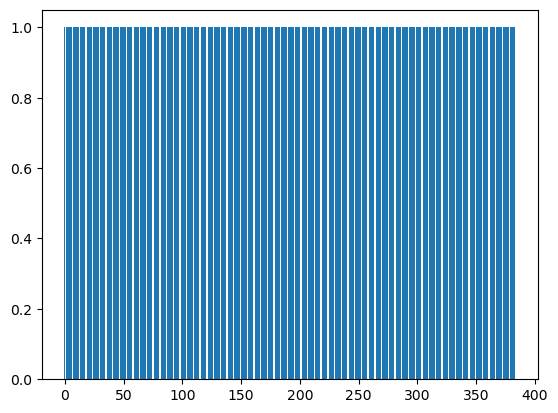

In [40]:
import matplotlib.pyplot as plt
plt.bar(range(len(test_vector)), test_vector.flatten())
plt.show()

In [41]:
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

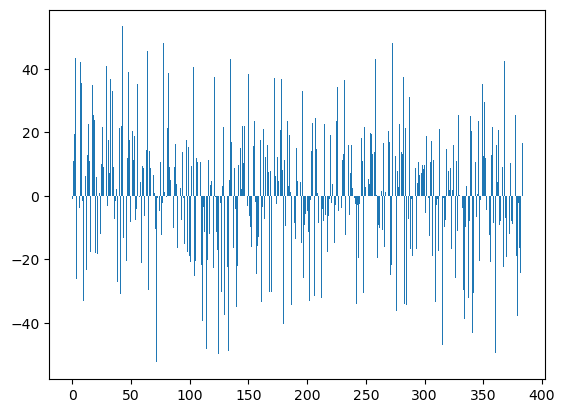

In [42]:
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [43]:
query_embeddings         = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings         = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|█████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.04it/s]


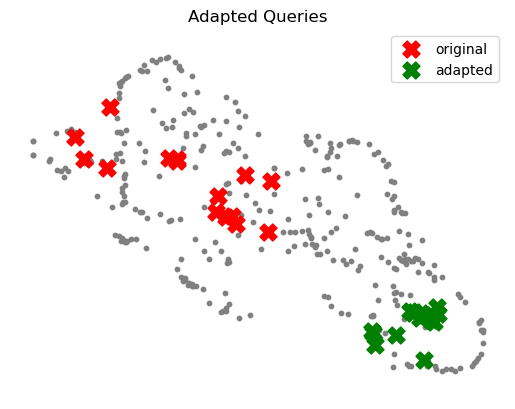

In [44]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()

#### Key notes

- Use of proper prompts
- Use of LLMs (need for experimentation)
- Use NN , instead of matrix mul for better results; Deep embedding adaptor
- Generation of better synthetic data (user data)

- Fine tuning LLM
- Deep Chunking